It is often hard to find a large collection of correctly labelled data. This scarcity of labelled real data exists for gravitational waves as well. One way to combat this shortage is to train on simulated data and hope the trained model is useful for the real dataset as well. The success of such an approach is dependant on the quality of simulation. However, astronomy doesn't have a shortage of raw data. So, I felt the application of semi-supervised training approach is particularly relevant for this task. One of the main components of semi-supervised training is the augmentation scheme. However in my experiments I found that it extremely difficult to come up with a good augmentation for this dataset.

While thinking on how to augment the data such that the signal characteristic is preserved, I realized that we already have an augmented dataset! My main insight was that whenever there is a gravitational wave, all three detectors must detect it. So, we can imagine that we have access to augmented versions of the same signal. The different geographical position and noise characteristic already takes care of the augmentation :-)

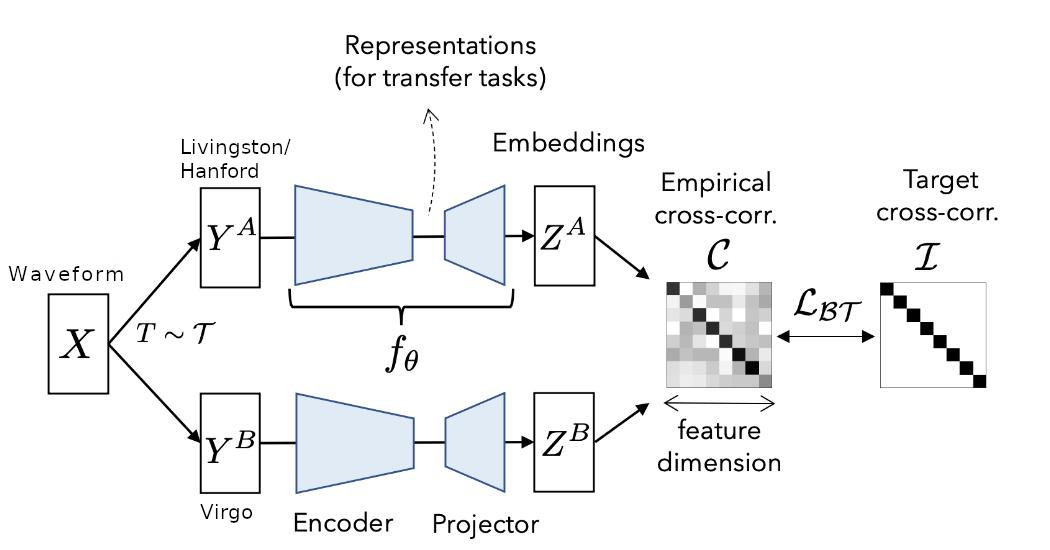

I used the recently proposed Barlow Twins method for semi-supervised training. I would highly recommend going through the paper to understand the details. The basic idea is to have two models which see different versions of data (in our case the gravitational wave signal) and use the barlow twin's objective function to learn embeddings. While training on imagenet, people generally use cropping, flipping, blurring, random contrast etc
to create different versions of the same image. 

In our case, we can feed the data from Hanford/Livingston into Net 1 and data from the Virgo detector into Net 2. Since the noise in Virgo detector is quite different from Hanford/Livingston, we can imagine it as an augmented sample of the same underlying signal.

# Useful links:
- [Project Github Repo](https://github.com/sidml/Self-Supervised-Learning-for-Gravitational-Waves)
- [Barlow Twins Paper](https://arxiv.org/pdf/2103.03230.pdf)
- [Gravitational Wave Dataset](https://www.kaggle.com/c/g2net-gravitational-wave-detection/data)
- [1D CNN trained using supervised learning](https://www.kaggle.com/scaomath/g2net-1d-cnn-gem-pool-pytorch-train-inference)

In [ ]:
!git clone https://github.com/sidml/Self-Supervised-Learning-for-Gravitational-Waves.git

In [ ]:
cd Self-Supervised-Learning-for-Gravitational-Waves

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pdb
pd.set_option("display.max_columns", None)
import cv2

import matplotlib
import matplotlib.pyplot as plt

matplotlib.use("Agg")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import torchvision.transforms as T
import pdb

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning import seed_everything

import random
from collections import OrderedDict
import os, gc, time
from glob import glob
from functools import partial
from tqdm.auto import tqdm

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
)

from pl_model import G2Net, G2NetEval
from cnn1d_models import NetEval
from dataset import GWDatasetBandpass

from utils import average_model, get_file_path

import warnings

warnings.filterwarnings("ignore")

In [ ]:
class Config:
    batch_size = 456
    weight_decay = 1e-8
    lr = 5e-5
    num_workers = 4
    epochs = 4
    model_name = 'cnn1d_aug'
    suffix = "barlow"
    ROOT = "/kaggle/input/g2net-gravitational-wave-detection"
    TRAIN_ROOT = f"{ROOT}/train/"
    NOISE_DIR = f"/kaggle/input/gwdet-noise"
    TEST_ROOT = f"{ROOT}/test/"
    SUB_DIR = "./submissions/"
    
config = Config()

In [ ]:
seed_everything(42, workers=True)
print("PL_SEED_WORKERS=" + os.environ["PL_SEED_WORKERS"])
config = Config()
train_labels = pd.read_csv(f"{config.ROOT}/training_labels.csv")
# bce loss requires labels to be of float type
train_labels["target"] = train_labels["target"].astype(np.float32)

get_path = partial(get_file_path, config.TRAIN_ROOT)
train_labels["file_path"] = train_labels["id"].apply(get_path)
print(train_labels.head())

In [ ]:
trn_idx = np.random.randint(0, len(train_labels), (int(len(train_labels)*0.9),))
val_idx = np.array(list(set(range(len(train_labels))) - set(trn_idx)))
train_df = train_labels.loc[trn_idx].reset_index(drop=True)
val_df = train_labels.loc[val_idx].reset_index(drop=True)

print(f'Training with {len(trn_idx)}, validation with {len(val_df)}')

# Train barlow twins using self-supervised learning

Currently most semi-supervised work is focused on images. So, usually inputs are images and 2D CNN is used as model. However, for faster training I decided to train using waveforms. I trained a 1D CNN model inspired by [this post](https://www.kaggle.com/scaomath/g2net-1d-cnn-gem-pool-pytorch-train-inference). I observed that adding a GRU layer and reducing the original pooling size led to better results. I also removed the final fully connected layers since we require the models to produce embeddings. The bandpassed waveforms are fed as input to the model and we get embeddings of size 2048 as output.

The output embeddings produced by both the networks are normalized along the batch dimension and we calculate the invariance and redundancy reduction terms. Using these terms, we get the final loss used for training the networks. In the original paper, they used LARS optimizer but I found that AdamW with an initial learning rate of 1e-4 also works. (I haven't tried LARS optimizer yet, so maybe it will work even better.) Currently, I am only using pycbc generated noise as an additional augmentation. 

In [ ]:
model = G2Net(config=config, train_df=train_df, val_df=val_df)
ckpt_dir = "/kaggle/input/self-supervised-method-for-gravitation-wave-det/Self-Supervised-Learning-for-Gravitational-Waves/cnn1d_aug_barlow"
paths = glob(f"{ckpt_dir}/lightning_logs/version_0/checkpoints/*.ckpt")
averaged_w = average_model(paths)
model.model.load_state_dict(averaged_w, strict=True)
del averaged_w; torch.cuda.empty_cache(); gc.collect()

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    filename="{epoch:02d}-{val_loss_epoch:.3f}",
    mode="min",
    save_top_k=5,
    save_weights_only=True,
)
early_stopping = EarlyStopping(
    monitor="val_loss", mode="min", patience=10, verbose=True
)
trainer = Trainer(
    max_epochs=config.epochs,
    progress_bar_refresh_rate=10,
    limit_val_batches=0.2,
    val_check_interval=0.5,
    amp_level='O2',
    precision=16,
    gpus=1,
    default_root_dir=f"{config.model_name}_{config.suffix}",
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback, early_stopping],
)
trainer.fit(model)

# Freeze backbone layers and finetune FC

After training the 1D CNN based model, we are able to get embeddings of the input waveform. Now, we need to train a Fully connected (FC) layer to make final prediction. For this we obtain embeddings for all the three detectors. Embeddings for Hanford/Livingston are obtained from Net 1 and Net 2 provides the Virgo embedding. The concatenation of all the embeddings is used as input to the FC layer.

During the FC layer training, we freeze the backbone layer weights (net 1 & 2) and only train the FC layer on a subset of training dataset (i used 25% of the dataset). It is sufficient to train FC layer for 7-8 epochs. Once the FC training is complete, we can use the model to detect GW.

In [ ]:
config.epochs = 8
config.batch_size = 512
config.model_name = 'cnn1d_aug'
config.suffix = "eval"
ckpt_dir = "./cnn1d_aug_barlow/lightning_logs/version_0/checkpoints/"
config.weight_paths = glob(f"{ckpt_dir}/*.ckpt")
model = G2NetEval(config=config, train_df=train_df, val_df=val_df)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    filename="{epoch:02d}-{val_loss_epoch:.3f}",
    mode="min",
    save_top_k=5,
    save_weights_only=True,
)
early_stopping = EarlyStopping(
    monitor="val_loss", mode="min", patience=5, verbose=True
)
trainer = Trainer(
    max_epochs=config.epochs,
    progress_bar_refresh_rate=10,
    limit_train_batches=0.25,
    limit_val_batches=0.2,
    gpus=1,
    default_root_dir=f"{config.model_name}_{config.suffix}",
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback, early_stopping],
)
trainer.fit(model)


# Validation set result

In [ ]:
root_dir = (
    f"./{config.model_name}_{config.suffix}/lightning_logs"
)
paths = list(glob(f"{root_dir}/version_0/checkpoints/*.ckpt"))

print(paths)
model = NetEval(config.weight_paths)
averaged_w = average_model(paths)
model.load_state_dict(averaged_w)
model.eval()
device = 'cuda'
model.to(device)
val_idx = val_idx[:40000]
val_df = train_labels.loc[val_idx].reset_index(drop=True)
dataset = GWDatasetBandpass(val_df, mode="val")
test_loader = DataLoader(
    dataset,
    batch_size=int(config.batch_size),
    num_workers=config.num_workers,
    shuffle=False,
    drop_last=False,
)
tk = tqdm(test_loader, total=len(test_loader))
sub_index = val_df.id.values
idx = 0
cv_preds = train_labels.copy(deep=True)
cv_preds["preds"] = None
cv_preds = cv_preds.set_index("id")

with torch.no_grad():
    for i, (im, _) in enumerate(tk):
        im = im.to(device)
        preds = model(im, mode='val').reshape(
            -1,
        )
        o = preds.sigmoid().cpu().numpy()
        for offset, val in enumerate(o):
            cv_preds.loc[sub_index[idx], "preds"] = val
            idx += 1

t = cv_preds.loc[sub_index]
auc = roc_auc_score(t["target"], t["preds"])
print(f"\nAUC:{auc:.4f}")
print(t["preds"].astype(np.float32).describe())
torch.cuda.empty_cache()
gc.collect()
time.sleep(2)

cv_preds = cv_preds.dropna()
cv_preds["preds"] = cv_preds["preds"].astype(np.float32)
cv_preds.to_csv(f"cv_{config.model_name}_{config.suffix}.csv", index=True)
print(cv_preds.head())
print(cv_preds["preds"].describe())
auc = roc_auc_score(cv_preds.loc[:, "target"], cv_preds.loc[:, "preds"])
print("auc score", auc)

# Make Test set predictions for LB evaluation

In [ ]:
os.makedirs(config.SUB_DIR, exist_ok=True)
# # Test predictions
sub = pd.read_csv(f"{config.ROOT}/sample_submission.csv")
sub.loc[:, "target"] = 0.0  # init to 0
get_path = partial(get_file_path, config.TEST_ROOT)
sub["file_path"] = sub["id"].apply(get_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = f"./{config.model_name}_{config.suffix}/lightning_logs"
paths = list(glob(f"{root_dir}/version_0/checkpoints/*.ckpt"))
print(paths)
model = NetEval(paths, mode='val').to(device)
averaged_w = average_model(paths)
model.load_state_dict(averaged_w)
model.eval();

In [ ]:
dataset = GWDatasetBandpass(sub, mode="test")
test_loader = DataLoader(
    dataset,
    batch_size=int(config.batch_size),
    num_workers=4,
    shuffle=False,
    drop_last=False,
)
tk = tqdm(test_loader, total=len(test_loader))
sub_index = 0
with torch.no_grad():
    for i, (waves, _) in enumerate(tk):
        waves = waves.to(device)
        preds = model(waves,
                      mode="test").reshape(-1,)
        o = preds.sigmoid().cpu().numpy()
        for val in o:
            sub.loc[sub_index, "target"] = val
            sub_index += 1
sub = sub.drop("file_path", axis=1)
sub_path = (
    f"{config.SUB_DIR}/submission_{config.model_name}_{config.suffix}.csv"
)
sub.to_csv(sub_path, index=False)
print(sub.head())
print(sub.loc[:, "target"].describe())

# Possible future work:

- Try this semi-supervised approach with 2D CNN model. In this case, instead of using direct waveforms we can use the extracted CQT features.
- Different 1d CNN architectures.
- New Augmentations
- Tuning the lambda parameter in barlow twins loss


In [ ]:
!rm *.py
!find . | grep -E "(__pycache__|\.pyc|\.pyo$)" | xargs rm -rf
!rm -rf ./.git